# Setting up database (businesses)

In [323]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

bdf = pd.read_json('./data/original_business.json', lines=True)

bdf_filtered = bdf[bdf['review_count'] > 20]    #remove restuarants that have less than 20 reviews
#bdf_filtered = bdf_filtered.sample(n=10000, random_state=42)  #reduce to 10k

bdf = bdf_filtered[['business_id', 'name', 'stars', 'review_count']]

In [324]:
bdf.head()

,business_id,name,stars,review_count
2,tUFrWirKiKi_TAnsVWINQQ,Target,3.5,22
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,4.0,80
12,il_Ro8jwPlHresjw9EGmBg,Denny's,2.5,28
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,4.5,100
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,4.0,245


# Setting up database (review)

In [325]:
valied_business_ids = bdf['business_id'].unique()   #get business_id of bdf_sampled data frame

rdf = pd.read_json('./data/reviews_500k.json', lines=True)
rdf = rdf[rdf['business_id'].isin(valied_business_ids)]

"""
rdf_filtered = []

with open('./data/reviews_oneMil.json') as file:
    for line in file:
        try:
            review = json.loads(line)
            if review['business_id'] in valied_business_ids:    #remove all reviews which are not in bdf_sampled
                rdf_filtered.append(review)
        except:
            print("Error decoding JSON: ", line)

rdf_filtered = pd.DataFrame(rdf_filtered)
"""

rdf = rdf[['review_id', 'business_id', 'text']]

In [326]:
rdf.head()

,review_id,business_id,text
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,"If you decide to eat here, just be aware it is..."
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,I've taken a lot of spin classes over the year...
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,Family diner. Had the buffet. Eclectic assortm...
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,"Wow! Yummy, different, delicious. Our favo..."
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,Cute interior and owner (?) gave us tour of up...


# Group the review text with its corresponding business

In [327]:
#Grouping the business_id with all the review text that corresponds to that business
grouped_reviews = rdf.groupby('business_id')['text'].apply(' '.join).reset_index()
#merged_df = pd.merge(bdf, rdf, on='business_id')
#merged_df.drop('review_id', axis=1, inplace=True)
#merged_df.head()
grouped_reviews

,business_id,text
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...
1,-02xFuruu85XmDn2xiynJw,Dr. Curtis Dechant has an excellent chair-side...
2,-0E7laYjwZxEAQPhFJXxow,I recently visited this dealership because the...
3,-0Ym1Wg3bXd_TDz8JtvOQg,I'm a little late to the party and have been m...
4,-1MhPXk1FglglUAmuPLIGg,Great food and drink. The staff are always fri...
...,...,...
6051,zxpJ4Frr8Zoru-YaNzOxzw,Let's be serious. This is Nashville--there ai...
6052,zxuVnNVAUm16Sro0dS_lmg,Excellent! Love the location-- fun upscale dec...
6053,zzHtFjfM7NvuVM1HTsCLGA,I had the smoked salmon ramen special. The bro...
6054,zzUxvYE-8Fj_dWqsPcagNg,I have been using these guys for two years in ...


# Calculate TF-IDF

In [328]:
#Possibly create our own vocabulary

vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.9, min_df = 0.01)
tfidf_matrix = vectorizer.fit_transform(grouped_reviews['text'])
tfidf_feature_names = vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_feature_names)

#tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped_reviews['business_id'], columns=tfidf.get_feature_names_out())

tfidf_df

,00,000,00am,00pm,01,02,03,04,05,06,...,zero,zest,zesty,zing,zip,ziti,zombie,zone,zoo,zucchini
0,0.015617,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.073142,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003637,0.000000,0.0,0.007229,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.006805,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6051,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6052,0.008556,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6053,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6054,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Filter Top 10,000 words based on TF-IDF score

In [329]:
avg_tfidf_scores = tfidf_df.mean(axis=0)   #get average scores

sorted_tfidf = avg_tfidf_scores.sort_values(ascending=False)    #sort
top_10000_words = sorted_tfidf.head(10000).index
top_tfidf_df = tfidf_df[top_10000_words]
top_tfidf_df['business_id'] = grouped_reviews['business_id']
top_tfidf_df

C:\Users\taekjinjung\AppData\Local\Temp\ipykernel_4700\1719654688.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_tfidf_df['business_id'] = grouped_reviews['business_id']


,food,pizza,chicken,order,ordered,restaurant,staff,delicious,bar,menu,...,impersonal,contribute,tepid,explicitly,serviceable,sided,duper,disconnect,flows,business_id
0,0.000000,0.100269,0.027062,0.052674,0.045984,0.012893,0.036378,0.073379,0.000000,0.012769,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,--ZVrH2X2QXBFdCilbirsw
1,0.000000,0.000000,0.000000,0.013683,0.007466,0.000000,0.100400,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-02xFuruu85XmDn2xiynJw
2,0.000000,0.000000,0.000000,0.013379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0E7laYjwZxEAQPhFJXxow
3,0.000000,0.000000,0.000000,0.014720,0.008032,0.000000,0.014826,0.074052,0.000000,0.035684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0Ym1Wg3bXd_TDz8JtvOQg
4,0.273250,0.000000,0.024301,0.018920,0.049551,0.018524,0.078398,0.030749,0.375446,0.036691,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1MhPXk1FglglUAmuPLIGg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6051,0.308012,0.000000,0.153397,0.238860,0.081454,0.036541,0.038663,0.017331,0.000000,0.054283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,zxpJ4Frr8Zoru-YaNzOxzw
6052,0.335409,0.029297,0.086486,0.061563,0.142759,0.160105,0.068093,0.131770,0.124606,0.135245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,zxuVnNVAUm16Sro0dS_lmg
6053,0.029976,0.000000,0.009330,0.021793,0.023781,0.044451,0.006271,0.016866,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,zzHtFjfM7NvuVM1HTsCLGA
6054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,zzUxvYE-8Fj_dWqsPcagNg


# Add the columns to the merged data frame

In [330]:
#text_df = grouped_reviews[['business_id', 'text']]
#grouped_reviews.drop('text', axis=1, inplace=True)
merged_df = pd.merge(bdf, rdf, on='business_id')
merged_df.drop('review_id', axis=1, inplace=True)
merged_df.drop('text', axis=1, inplace=True)
merged_df = merged_df.drop_duplicates(subset='business_id', keep='first')

merged_df = pd.merge(merged_df, top_tfidf_df, on='business_id')

In [331]:
merged_df = merged_df.sort_values('business_id')
merged_df

,business_id,name,stars_x,review_count,food,pizza,chicken,order,ordered,restaurant,...,perfected,impersonal,contribute,tepid,explicitly,serviceable,sided,duper,disconnect,flows
3760,--ZVrH2X2QXBFdCilbirsw,Chris's Sandwich Shop,4.5,32,0.000000,0.100269,0.027062,0.052674,0.045984,0.012893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2251,-02xFuruu85XmDn2xiynJw,Family Vision Center,4.5,109,0.000000,0.000000,0.000000,0.013683,0.007466,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5706,-0E7laYjwZxEAQPhFJXxow,AutoNation Cadillac Port Richey,3.5,25,0.000000,0.000000,0.000000,0.013379,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3350,-0Ym1Wg3bXd_TDz8JtvOQg,Yelo'd Ice Cream,4.5,105,0.000000,0.000000,0.000000,0.014720,0.008032,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5631,-1MhPXk1FglglUAmuPLIGg,Red Garter Saloon,4.0,107,0.273250,0.000000,0.024301,0.018920,0.049551,0.018524,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,zxpJ4Frr8Zoru-YaNzOxzw,China Spring,3.5,33,0.308012,0.000000,0.153397,0.238860,0.081454,0.036541,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1349,zxuVnNVAUm16Sro0dS_lmg,Roundabout Grill,4.0,244,0.335409,0.029297,0.086486,0.061563,0.142759,0.160105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,zzHtFjfM7NvuVM1HTsCLGA,Nom Nom Japanese Kitchen,4.5,35,0.029976,0.000000,0.009330,0.021793,0.023781,0.044451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116,zzUxvYE-8Fj_dWqsPcagNg,The Cleaning Authority - Tucson,2.0,25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Done datasets!!

# Methods Library

In [332]:
from collections.abc import Sequence

def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

def drop_two_columns(df, column1 = 'business_id', column2 = 'name'):
    df.drop(column1, axis=1, inplace=True)
    df.drop(column2, axis=1, inplace=True)
    return df

### Split data into training and test using train_test_split

In [333]:
#menage data frame to create better model
names = merged_df['name']
df = drop_two_columns(merged_df)
missing_median(df, 'stars_x')
missing_median(df, 'review_count')

encode_numeric_zscore(df, 'review_count')

In [334]:
x,y = to_xy(df, "stars_x")

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.25, random_state=45)

model = Sequential()
input_size = x_train.shape[1]

#Input layer
model.add(Dense(64, input_dim=input_size, activation='relu'))
model.add(Dense(32, activation='relu'))
#Output layer
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

c:\Users\taekjinjung\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
142/142 - 2s - 14ms/step - loss: 2.3225 - val_loss: 0.5319
Epoch 2/1000
142/142 - 1s - 6ms/step - loss: 0.2889 - val_loss: 0.2632
Epoch 3/1000
142/142 - 1s - 5ms/step - loss: 0.1393 - val_loss: 0.2285
Epoch 4/1000
142/142 - 1s - 4ms/step - loss: 0.0829 - val_loss: 0.2115
Epoch 5/1000
142/142 - 1s - 4ms/step - loss: 0.0527 - val_loss: 0.2123
Epoch 6/1000
142/142 - 1s - 5ms/step - loss: 0.0359 - val_loss: 0.2118
Epoch 7/1000
142/142 - 1s - 6ms/step - loss: 0.0254 - val_loss: 0.2147
Epoch 8/1000
142/142 - 1s - 5ms/step - loss: 0.0175 - val_loss: 0.2194
Epoch 9/1000
142/142 - 1s - 5ms/step - loss: 0.0125 - val_loss: 0.2175
Epoch 9: early stopping


In [335]:
# Predict and measure RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Score (RMSE): 0.46640488505363464


In [355]:
# print out prediction
df_y = pd.DataFrame(y_test, columns=['True Stars'])
df_pred = pd.DataFrame(pred, columns=['predicted'])
result = pd.concat([df_y, df_pred],axis=1)
result

,True Stars,predicted
0,3.0,3.436201
1,3.0,2.995454
2,4.5,4.035199
3,3.0,3.238265
4,3.0,3.173602
...,...,...
1509,4.0,3.520657
1510,3.5,3.439226
1511,4.0,4.686953
1512,3.5,3.870718


# Visualizing (Regression Models)

In [337]:
#Imports and Methods
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

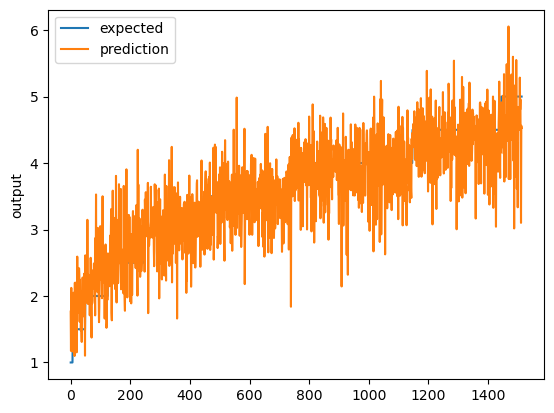

In [342]:
# Plot the chart
chart_regression(pred.flatten(),y_test, sort=True)

# Prediction with 5 businesses

In [354]:
# Sample predictions
for i in range(5):
    print("{}. Business Name: {}, Stars: {}, predicted Stars: {}".format(i+1,names[i],y_test[i],pred[i]))

1. Business Name: Target, Stars: 3.0, predicted Stars: [3.4362006]
2. Business Name: St Honore Pastries, Stars: 3.0, predicted Stars: [2.995454]
3. Business Name: Denny's, Stars: 4.5, predicted Stars: [4.035199]
4. Business Name: Zio's Italian Market, Stars: 3.0, predicted Stars: [3.238265]
5. Business Name: Tuna Bar, Stars: 3.0, predicted Stars: [3.1736019]
